# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 464 µs (started: 2023-02-18 17:34:17 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, 
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 2.77 s (started: 2023-02-18 17:34:17 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

print('versión Keras:', keras.__version__)

versión Keras: 2.11.0
time: 1.15 ms (started: 2023-02-18 17:34:20 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.04 s (started: 2023-02-18 17:34:20 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_9G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, custom_model, WEIGHTS_PATH, DNN_NAME, TYPE_IMG, TFM_PATH, USE_DATA_AUG):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - WEIGHTS_PATH = Ruta en drive a la carpeta de los pesos
        - custom_model = Modelo de Deep Learning
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print('------ Model Saved -------')


time: 6.6 ms (started: 2023-02-18 17:34:22 +00:00)


# Imgs 64x64

- Test Accuracy: 0.49327149987220764
- Test Loss: 2.9018778800964355
- time: 4h 58min 29s
- F1 score: 0.4923462622815324
- Precision score: 0.513389087932539
- Recall:  0.49327150084317034
- Epoch: 50/50

## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 563 µs (started: 2023-02-16 16:27:59 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 32.4 s (started: 2023-02-16 16:28:00 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.17 ms (started: 2023-02-16 16:28:33 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 12s 0us/step
time: 20.7 s (started: 2023-02-16 16:28:33 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 396s 27ms/step - loss: 5.9756 - sparse_categorical_accuracy: 0.1169 - val_loss: 5.1396 - val_sparse_categorical_accuracy: 0.1932
Epoch 2/50
13899/13899 [==============================] - 382s 27ms/step - loss: 4.5084 - sparse_categorical_accuracy: 0.2722 - val_loss: 4.4626 - val_sparse_categorical_accuracy: 0.2680
Epoch 3/50
13899/13899 [==============================] - 372s 27ms/step - loss: 3.8573 - sparse_categorical_accuracy: 0.3523 - val_loss: 4.0792 - val_sparse_categorical_accuracy: 0.3109
Epoch 4/50
13899/13899 [==============================] - 371s 27ms/step - loss: 3.4308 - sparse_categorical_accuracy: 0.4069 - val_loss: 3.8250 - val_sparse_categorical_accuracy: 0.3394
Epoch 5/50
13899/13899 [==============================] - 369s 27ms/step - loss: 3.1200 - sparse_categorical_accuracy: 0.4491 - val_loss: 3.6368 - val_sparse_categorical_accuracy: 0.3641
Epoch 6/50
13899/13899 [==============================] - 370s 27

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.53 s (started: 2023-02-16 21:27:26 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 44s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.49327149987220764
- Test Loss: 2.9018778800964355
- time: 
- F1 score: 0.4923462622815324
- Precision score: 0.513389087932539
- Recall:  0.49327150084317034
- Epoch: 
*********************************************************************************************************************************
time: 1min 31s (started: 2023-02-16 21:27:30 +00:00)


## Graficando

In [ ]:
plot_loss(history)

In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 3.13 s (started: 2023-02-16 21:29:02 +00:00)


# Imgs 96x96

- Test Accuracy: 0.5734907388687134
- Test Loss: 2.452873945236206
- time: 5h 55min 52s
- F1 score: 0.5737718156815871
- Precision score: 0.5934471695631056
- Recall:  0.5734907251264756
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 679 µs (started: 2023-02-17 17:53:51 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 3s (started: 2023-02-17 04:11:37 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1 ms (started: 2023-02-17 04:12:41 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 11s 0us/step
time: 19.8 s (started: 2023-02-17 04:12:41 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 96, 96, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 453s 31ms/step - loss: 6.2621 - sparse_categorical_accuracy: 0.1060 - val_loss: 5.4572 - val_sparse_categorical_accuracy: 0.1803
Epoch 2/50
13899/13899 [==============================] - 427s 31ms/step - loss: 4.8410 - sparse_categorical_accuracy: 0.2627 - val_loss: 4.7375 - val_sparse_categorical_accuracy: 0.2615
Epoch 3/50
13899/13899 [==============================] - 423s 30ms/step - loss: 4.1471 - sparse_categorical_accuracy: 0.3513 - val_loss: 4.2954 - val_sparse_categorical_accuracy: 0.3155
Epoch 4/50
13899/13899 [==============================] - 424s 31ms/step - loss: 3.6726 - sparse_categorical_accuracy: 0.4129 - val_loss: 3.9838 - val_sparse_categorical_accuracy: 0.3518
Epoch 5/50
13899/13899 [==============================] - 428s 31ms/step - loss: 3.3165 - sparse_categorical_accuracy: 0.4604 - val_loss: 3.7505 - val_sparse_categorical_accuracy: 0.3796
Epoch 6/50
13899/13899 [==============================] - 429s 31

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 9.13 s (started: 2023-02-17 17:54:07 +00:00)


## Métricas

In [ ]:
# Cargar modelo
MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME


print(WEIGHTS_PATH)

custom_model = keras.models.load_model(WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/etl9Gmodel_resnet152v2_etl9_imgs96_regular.h5
time: 1.2 ms (started: 2023-02-17 17:54:18 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 43s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5734907388687134
- Test Loss: 2.452873945236206
- time: 
- F1 score: 0.5737718156815871
- Precision score: 0.5934471695631056
- Recall:  0.5734907251264756
- Epoch: 
*********************************************************************************************************************************
time: 1min 43s (started: 2023-02-17 17:55:50 +00:00)


## Graficando

In [ ]:
plot_loss(history)

In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

# Imgs 112x112

- Test Accuracy: 0.6370489001274109
- Test Loss: 1.9357420206069946
- time: 5h 37min 29s
- F1 score: 0.6377894956704038
- Precision score: 0.6571820504226245
- Recall:  0.6370489038785835
- Epoch: 50/50



## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 824 µs (started: 2023-02-17 12:05:33 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 19s (started: 2023-02-17 12:05:33 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.12 ms (started: 2023-02-17 12:06:52 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 8.78 s (started: 2023-02-17 12:06:52 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 112, 112, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 430s 30ms/step - loss: 6.0469 - sparse_categorical_accuracy: 0.1255 - val_loss: 5.1349 - val_sparse_categorical_accuracy: 0.2188
Epoch 2/50
13899/13899 [==============================] - 404s 29ms/step - loss: 4.4713 - sparse_categorical_accuracy: 0.3088 - val_loss: 4.2986 - val_sparse_categorical_accuracy: 0.3180
Epoch 3/50
13899/13899 [==============================] - 402s 29ms/step - loss: 3.7057 - sparse_categorical_accuracy: 0.4090 - val_loss: 3.7989 - val_sparse_categorical_accuracy: 0.3762
Epoch 4/50
13899/13899 [==============================] - 402s 29ms/step - loss: 3.1953 - sparse_categorical_accuracy: 0.4782 - val_loss: 3.4579 - val_sparse_categorical_accuracy: 0.4186
Epoch 5/50
13899/13899 [==============================] - 406s 29ms/step - loss: 2.8223 - sparse_categorical_accuracy: 0.5306 - val_loss: 3.2002 - val_sparse_categorical_accuracy: 0.4505
Epoch 6/50
13899/13899 [==============================] - 404s 29

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 9.02 s (started: 2023-02-17 17:44:33 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 42s 21ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6370489001274109
- Test Loss: 1.9357420206069946
- time: 
- F1 score: 0.6377894956704038
- Precision score: 0.6571820504226245
- Recall:  0.6370489038785835
- Epoch: 
*********************************************************************************************************************************
time: 1min 36s (started: 2023-02-17 17:44:42 +00:00)


## Graficando

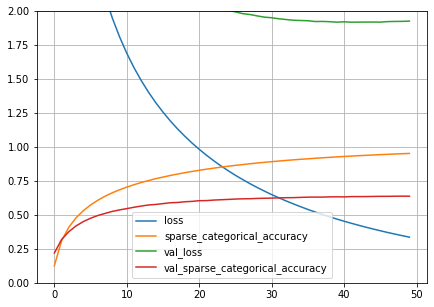

time: 372 ms (started: 2023-02-17 17:46:18 +00:00)


In [ ]:
plot_loss(history)

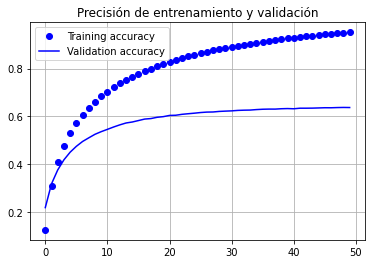

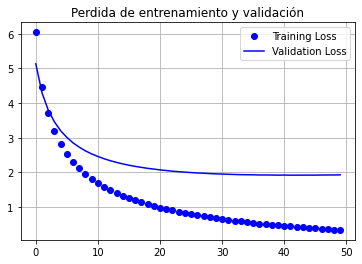

time: 352 ms (started: 2023-02-17 17:46:19 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 2.63 s (started: 2023-02-17 17:46:19 +00:00)


# Imgs 127x127

- Test Accuracy: 0.6823946237564087
- Test Loss: 1.6985509395599365
- time: 4h 46min 22s
- F1 score: 0.684083949819368
- Precision score: 0.6981258967339565
- Recall:  0.6823946037099494
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_v2/'
PATH = ROOT_PATH.format(SIZE)

print(PATH)

MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
            + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
            + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

print('Weights path:', WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_v2/
Weights path: /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/model_resnet152v2_etl9_imgs127_regular.h5
time: 1.75 ms (started: 2023-02-18 17:34:35 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 28s (started: 2023-02-18 12:44:04 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (355800, 127, 127, 1) and labels: (355800,)

- val images: (118600, 127, 127, 1) and labels: (118600,)

time: 1.02 ms (started: 2023-02-18 12:45:32 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 8.73 s (started: 2023-02-18 12:46:26 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
11119/11119 [==============================] - 370s 32ms/step - loss: 6.0081 - sparse_categorical_accuracy: 0.1296 - val_loss: 5.0925 - val_sparse_categorical_accuracy: 0.2302
Epoch 2/50
11119/11119 [==============================] - 340s 31ms/step - loss: 4.4114 - sparse_categorical_accuracy: 0.3280 - val_loss: 4.2549 - val_sparse_categorical_accuracy: 0.3300
Epoch 3/50
11119/11119 [==============================] - 339s 30ms/step - loss: 3.6288 - sparse_categorical_accuracy: 0.4369 - val_loss: 3.7454 - val_sparse_categorical_accuracy: 0.3941
Epoch 4/50
11119/11119 [==============================] - 339s 30ms/step - loss: 3.1001 - sparse_categorical_accuracy: 0.5129 - val_loss: 3.3824 - val_sparse_categorical_accuracy: 0.4403
Epoch 5/50
11119/11119 [==============================] - 340s 31ms/step - loss: 2.7079 - sparse_categorical_accuracy: 0.5679 - val_loss: 3.1130 - val_sparse_categorical_accuracy: 0.4767
Epoch 6/50
11119/11119 [==============================] - 339s 31

## Graficando

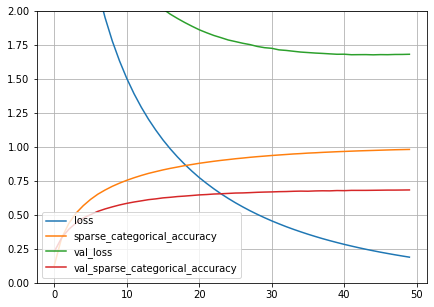

time: 275 ms (started: 2023-02-18 17:33:00 +00:00)


In [ ]:
plot_loss(history)

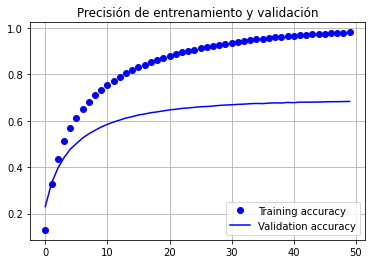

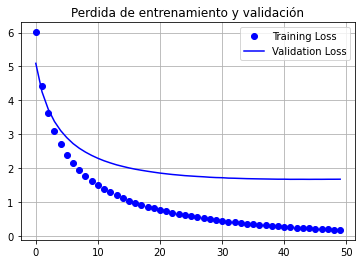

time: 374 ms (started: 2023-02-18 17:33:00 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(custom_model, WEIGHTS_PATH)

------ Model Saved -------
time: 3.23 s (started: 2023-02-18 17:33:01 +00:00)


## Métricas

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 23 s (started: 2023-02-18 17:34:44 +00:00)


In [ ]:
# Cargar modelo
custom_model = keras.models.load_model(WEIGHTS_PATH)

time: 20.5 s (started: 2023-02-18 17:35:07 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

3707/3707 [==============================] - 84s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6823946237564087
- Test Loss: 1.6985509395599365
- time: 
- F1 score: 0.684083949819368
- Precision score: 0.6981258967339565
- Recall:  0.6823946037099494
- Epoch: 
*********************************************************************************************************************************
time: 3min 16s (started: 2023-02-18 17:35:27 +00:00)


In [ ]:
runtime.unassign()
#quit()

time: 555 ms (started: 2023-02-18 17:38:44 +00:00)
